# Example of a Generative Adversarial Network


This notebook provides an example on how to build and train an adversarial generative network (GAN) for fast simulation of shower images produced by a high energy physics calorimeter detector. 

For this example we are using 2d projection in the transverse and longitudinal plane of 3d shower profiles of an high granularity electromagnetic calorimeter. The calorimeter is a prototype detector which has been studied for for a future linear collider experiment (CLIC).   

Using as input data obtained from full simulation of the detector we train a GAN with the aim to perform a fast simulation of the calorimeter. 

A detailed explanation on the original study using GAN for fast  is available in this publication:

*F. Carminati, A. Gheata, K. Gulrukh, P. Mendez Lorenzo, S. Sharan, S. Vallecorsa, Three dimensional Generative Adversarial Networks for fast simulation. Journal of Physics: Conference Series. 1085. 032016. 10.1088/1742-6596/1085/3/032016*

Here for simplicity and faster numerical computation, we are using a 2d propjection of the data and train a GAN consisting of 2d convolutional layer to re-generate this data. 

We provide in the notebook an example how to train the GAN, then how to generate events using a trained network model and we show also the comparison of the obtained showers with the original full simulated ones 




In [1]:
import keras.backend as K

import h5py 
import numpy as np

import matplotlib.pyplot as plt

#options for GPU running
import tensorflow as tf
session_config = tf.ConfigProto(log_device_placement=True)
session_config.gpu_options.allow_growth=True
session = tf.Session(config=session_config)
K.set_session(session)

#use theano (th) like image ordering :   color x width x height 
K.set_image_dim_ordering('th')

from keras.models import Model
from keras.optimizers import Adadelta, Adam, RMSprop
from keras.utils.generic_utils import Progbar
from sklearn.model_selection import train_test_split

from keras.layers import (Input, InputLayer, Dense, Reshape, Flatten, Lambda, merge,
                          Dropout, BatchNormalization, Activation, Embedding)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import (UpSampling2D, Conv2D, ZeroPadding2D,
                                        AveragePooling2D)

from keras.models import Model, Sequential
 

Using TensorFlow backend.


### Define the models

We define here some model parameters such as: 

* number of epochs used for training
* batch size
* size of the latent input (i.e. the input random data used for generating then the images)
* total number of events used for training

In [2]:
nb_epochs = 99
batch_size = 1000
latent_size = 100
nevt = 200000  # number of events used for (training and testing)
train_event_rate = 0.9     # rate of all events used for training, the rest will be used for testing the model
verbose = 'false'

flip_rate = 0.01 #  rate used to flip  fake/real simulated data labels in the discriminator
generator_train_iterations = 2   #  number of generator iteration done for each batch

load_initial_weights = False     # start training from an initial set of weights
# input name for the weights used for loading the initial model configuration when load_initial_weigts=True 
input_weights = "weights_epoch_50"
    

### Discriminator model

We create first the discriminator model using Keras sequential model building.
The model consists of 4 convolutional layer followd by a pooling layer and then a dense layer with a single output to discriminate real images from fake ones

In [3]:
d = Sequential(name='discriminator')

d.add(Conv2D(32, (5,5), data_format='channels_first', padding='same', input_shape=(1,25,25) ) ) 
d.add(LeakyReLU())
d.add(ZeroPadding2D((2,2)) )

d.add(Conv2D(8, (5, 5), data_format='channels_first', padding='valid'))
d.add(LeakyReLU())
d.add(BatchNormalization())      
d.add(ZeroPadding2D((2, 2)))

d.add(Conv2D(8, (5,5), data_format='channels_first', padding='valid'))
d.add(LeakyReLU())
d.add(BatchNormalization())
d.add(ZeroPadding2D((1, 1)))

d.add(Conv2D(8, (5, 5), data_format='channels_first', padding='valid'))
d.add(LeakyReLU())
d.add(BatchNormalization())
d.add(AveragePooling2D((2, 2)))
d.add(Flatten())

d.add(Dense(1, activation='sigmoid'))

discriminator = d
d.summary()
      

W0503 15:59:50.994183 140227861108544 deprecation.py:506] From /home/moneta/.local/lib/python3.6/site-packages/tensorflow/python/training/moving_averages.py:210: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 25, 25)        832       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 25, 25)        0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 32, 29, 29)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 25, 25)         6408      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 25, 25)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 25, 25)         100       
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 8, 29, 29)         0         
__________

### Create generator model

We create then the generator model. The model takes as input a vector of size `latent_size` and then a combination of convolutional layers and upsampling to get at the end an output image of 25x25 size. 

In [4]:
gen = Sequential(name='generator')

gen.add(Dense(64 * 7, input_dim=latent_size))
gen.add(Reshape((8, 7,8)))

gen.add(Conv2D(64, (6, 8), data_format='channels_first', padding='same', kernel_initializer='he_uniform'))
gen.add(LeakyReLU())
gen.add(BatchNormalization())

gen.add(UpSampling2D(size=(2, 2)))
gen.add(ZeroPadding2D((2, 0)))

gen.add(Conv2D(6, (5, 8), data_format='channels_first', kernel_initializer='he_uniform'))
gen.add(LeakyReLU())
gen.add(BatchNormalization())

gen.add(UpSampling2D(size=(2, 3)))
gen.add(ZeroPadding2D((0,3)))

gen.add(Conv2D(6, (3, 8), data_format='channels_first', kernel_initializer='he_uniform'))
gen.add(LeakyReLU())

gen.add(Conv2D(1, (2, 2), data_format='channels_first', use_bias=False, kernel_initializer='glorot_normal'))
gen.add(Activation('relu'))
    
generator = gen
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 448)               45248     
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 7, 8)           0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 7, 8)          24640     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64, 7, 8)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 64, 7, 8)          32        
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 64, 14, 16)        0         
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 64, 18, 16)        0         
__________

### Compile models

Now we compile the previously defined models

In [5]:
print('[INFO] Building discriminator')
    #discriminator.load_weights('veganweights/params_discriminator_epoch_019.hdf5')
discriminator.compile(optimizer=RMSprop(), loss='binary_crossentropy')


# build the generator
print('[INFO] Building generator')
#generator.load_weights('veganweights/params_generator_epoch_019.hdf5')
generator.compile( optimizer=RMSprop(), loss='binary_crossentropy')


[INFO] Building discriminator
[INFO] Building generator


### Make combined model

Now we make the combined GAN model. It is a combination of the generator and the discriminator, since the input data are the random fake data which are processed first by the generator and then by the discriminator. In this combined model the discrimionator weights are considered fixed. 
For making the combined model we use the Keras Functional model building, since we use as input to the discriminator the output of the generator. 

In [6]:
latent = Input(shape=(latent_size, ), name='latent_input')

fake_image = generator( latent)

discriminator.trainable = False
fake_disc_out = discriminator(fake_image)
combined = Model(inputs=[latent], outputs=[fake_disc_out], name='combined_model')

combined.compile( optimizer=RMSprop(), loss='binary_crossentropy')
combined.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
latent_input (InputLayer)    (None, 100)               0         
_________________________________________________________________
generator (Sequential)       (None, 1, 25, 25)         86216     
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 11717     
Total params: 97,933
Trainable params: 86,182
Non-trainable params: 11,751
_________________________________________________________________


### Get input data

We retrive now the input full simulated image data. The data consists of 2D 200,000 images with size 25x25. 
They are the x-z (transverse and longitudinal) projection of original 3D showers generated with full simulation (Geant4) of a high granumarity electromagnetic calorimteter detector prototype for CLIC, a future linear collider project. 

A detailed explanation on the orifinal data is available in this publication, 
*F. Carminati, A. Gheata, K. Gulrukh, P. Mendez Lorenzo, S. Sharan, S. Vallecorsa, Three dimensional Generative Adversarial Networks for fast simulation. Journal of Physics: Conference Series. 1085. 032016. 10.1088/1742-6596/1085/3/032016*



In [7]:
### Full data set is (~ 1 GB)
d=h5py.File("Ele_GAN_2D.h5",'r')

# the data consists of two items, the ECAL shower profile which is 200k x 1 x 25 x 25 and 
# the initial electron energy (name = 'target') that is a uniform distribution between [0,500] GeV. 
# we use only the ECAL shower profile and not the energy as input 


xd = d.get('ECAL')
print(xd.shape)
#e=d.get('target')
#print(e.shape)


print ('Number of events in file',xd.shape[0])

nx = xd.shape[2]
ny = xd.shape[3]
print('image size is :',nx,' x ',ny)

(200000, 1, 25, 25)
Number of events in file 200000
image size is : 25  x  25


In [8]:
#convert in input Numpy array
# the shape of the input should be a 4-th array 
# as   nevents x 1 x width x depth
X=np.array(xd[:nevt,:,:])

print('*** Input data shape ***')
print(X.shape)

*** Input data shape ***
(200000, 1, 25, 25)


### Define Training and Test data

we split here the input data in trainig and test sets

In [9]:
# remove unphysical values
X[X < 1e-6] = 0

# split in train and test data using the train_test_split function from sklearn
X_train, X_test  = train_test_split(X, train_size= train_event_rate)

print(X_train.shape)
print(X_test.shape)

nb_train, nb_test = X_train.shape[0], X_test.shape[0]

print('split input data in ',nb_train, 'train events and ',nb_test,'test events')

#convert to float32

X_train = X_train.astype(np.float32)  
X_test = X_test.astype(np.float32)


tot_epoch_done = 0

/home/moneta/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(180000, 1, 25, 25)
(20000, 1, 25, 25)
split input data in  180000 train events and  20000 test events


## GAN Training

For the training of the GAN we define first some convenient functions that we will use later. 
The functions we define are: 

*  **generate_random_data** to generate the input data for the generator. We generate data from a normal distribution with  zero mean and a sigma that varies for each event with the value drawn from a uniform distribution in the range [1,5]

*  **train_GAN_on batch** is a function performing a weights update using a batch of events (e.g. 100 events). It takes as input the original true data (the full simulated images) and using random data as input for the generator, it computes the loss functions first for the discriminator and then for the generator and update the weights using a gradient descent optimization algorithm.  

*  **test_GAN** is a function that using the current update weights of the generator network returns the generated image data and also coputes the test loss functions using the statistically independent test input data set.

* **train_GAN** is the function performing the full GAN training on the given number of epochs. It calls for each batch of events in an apoch the *train_GAN_on batch* function and then for each epoch tests the model state with the  *test_GAN* function. 

We also define a function **bit_flips** that is used to flip randomly some of the labels (e.g. 5%) for the discriminator. This is useful to avoid that the discriminator gets stuck (vanishing gradients) and its weights are  not updated anymore 


In [10]:
def bit_flip(x, prob=flip_rate):
    """ flips a int array's values with some probability """
    x = np.array(x)
    selection = np.random.uniform(0, 1, x.shape) < prob
    x[selection] = 1 * np.logical_not(x[selection])
    return x

### Function *generate_random_data*

In [11]:
# generate an array of n x input_size  random events for the generator input 
# we generate from a N(0,s) where s is from a uniform distribution in [1,5] 
def generate_random_data(n): 
    noise = np.random.normal(0, 1, (n, latent_size) ) 
    sampled_energies = np.random.uniform(1, 5, (n,1) )
    random_data = np.multiply(sampled_energies, noise)
    return random_data

### Function *train_GAN_on_batch* 

Training of the GAN on a single batch. Please note the following tricks used commonly in order to better stabilize the training: 

*  The loss function for the generator to optimize is *max(log (D))* instead of *min(log (1-D))*. This formulation suffer less from vanishing gradients. 
*  Some of the labels are randomly flip with a low probability ( ~ 1%) when training the discriminator
*  Train the discriminator on separate batches for real and fake data

In [12]:
def train_GAN_on_batch(image_batch): 
    
        #generate input random data for generator 
        generator_input = generate_random_data(batch_size)
        
        # perform generator prediction
        generated_images = generator.predict(generator_input, verbose=False)

        # train discriminator on real batch and fake batch 
        # real batch will have label 1 and fake label 0
        # we use also a trick to flip randomly some small percentage of labels
        real_batch_loss = discriminator.train_on_batch(image_batch, bit_flip(np.ones(batch_size))) 
        fake_batch_loss = discriminator.train_on_batch(generated_images, bit_flip(np.zeros(batch_size))) 
  
        # compute total discriminator loss 
        discriminator_loss = (real_batch_loss + fake_batch_loss)/2
        
 
        #do some training iteration on the generator
        #   (e.g. 2 times to compensate fact we train discriminator two times)
        
        gen_losses = []                                                       
        for _   in range(generator_train_iterations) :                                                    
        #generate input random to generator
            noise = np.random.normal(0, 1, (batch_size, latent_size))
            sampled_energies = np.random.uniform(1, 5, ( batch_size,1 ))
            generator_input = np.multiply(sampled_energies, noise)


            # train generator and compute its loss
            gloss = combined.train_on_batch( generator_input, np.ones(batch_size))
            gen_losses.append(gloss)
        
        #compute mean generator loss of all the losses we have obtained
        generator_loss = np.mean(gen_losses)

        return discriminator_loss, generator_loss
                              
  
    

### Function *test_GAN*

In [13]:
#function definining test of GAN that will be run for each single epoch
def test_GAN(): 
    
    # generate test random data for giving as input to the generator and 
    # use after to compute the discriminator loss
    generator_input = generate_random_data(nb_test)
    
    # generate 'fake' images with generator
    generated_images = generator.predict(generator_input, verbose=False)
    #print('shape generated images',generated_images.shape)

    # compute now discriminator loss from fake (label = 0) vs true (label = 1) images
                              
    X = np.concatenate((X_test, generated_images))
    y = np.array([1] * nb_test + [0] * nb_test)                              
    discriminator_test_loss = discriminator.evaluate(X, y, verbose=False, batch_size=batch_size)

     
    # we generate also some other random input data for computing the loss function for the generator
    #  use 2 x data_size to have same statistics as for discriminator
    generator_input = generate_random_data(2 * nb_test)  
    # as labels we use 1 the value we input when training 
    y = np.ones(2 * nb_test)

    generator_test_loss = combined.evaluate(generator_input, y, verbose=False, batch_size=batch_size)
    
    return discriminator_test_loss, generator_test_loss, generated_images


### Function train_GAN

In [14]:
def train_GAN(nepochs, plots, fig): 
    #loop on number of epochs
    for epoch in range(nepochs):
        print('Epoch ',epoch + 1,' of ', nepochs)

        nb_batches = int(X_train.shape[0] / batch_size)
        if verbose:
            progress_bar = Progbar(target=nb_batches)

        epoch_gen_loss = []
        epoch_disc_loss = []
        
        #loop on the batches 
        for index in range(nb_batches):
            if verbose:
                progress_bar.update(index)
            else:
                if index % 1 == 0:
                    print('processed {}/{} batches'.format(index + 1, nb_batches))
                    
            image_batch = X_train[index * batch_size:(index + 1) * batch_size]
                    
            discrim_loss, generator_loss = train_GAN_on_batch(image_batch)

            # we save the losses
            epoch_disc_loss.append(discrim_loss)
            epoch_gen_loss.append( generator_loss )
                              
                          

        # after all batch we compute mean of train losses
    
        discriminator_train_loss = np.mean(np.array(epoch_disc_loss), axis=0)
        generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)
    
        #### TESTING   
        print('\nTesting for epoch :' , epoch + 1)

        discriminator_test_loss, generator_test_loss, X_gen = test_GAN()

        print('generator  train and test loss', generator_train_loss, generator_test_loss)
        print('discrimin. train and test loss', discriminator_train_loss, discriminator_test_loss)

        train_loss.append([discriminator_train_loss, generator_train_loss])
        test_loss.append([discriminator_test_loss, generator_test_loss])
    

        xdata.append(epoch+1)
    
        plots[0].set_xdata(xdata)
        plots[1].set_xdata(xdata)
        plots[2].set_xdata(xdata)
        plots[3].set_xdata(xdata)
    
        plots[0].set_ydata(np.array(train_loss)[:,0])
        plots[1].set_ydata(np.array(test_loss)[:,0])
        plots[2].set_ydata(np.array(train_loss)[:,1])
        plots[3].set_ydata(np.array(test_loss)[:,1])
    
        fig.canvas.draw()
        #end loop on epochs
        
    # return the generated images for testing
    return X_gen

### Load initial weights

Optionally we can load a initial set of weights for both discriminator and generator

In [15]:
#in case we what to start an initial configuration
load_initial_weights = True
if (load_initial_weights):
    generator_weights = 'generator_' + input_weights + '.h5'
    discriminator_weights = 'discriminator_' + input_weights + '.h5'
    print('loading weight files:',generator_weights,discriminator_weights)
    generator.load_weights(generator_weights)
    discriminator.load_weights(discriminator_weights)
    

loading weight files: generator_weights_epoch_50.h5 discriminator_weights_epoch_50.h5


### Perform the GAN training 

<IPython.core.display.Javascript object>


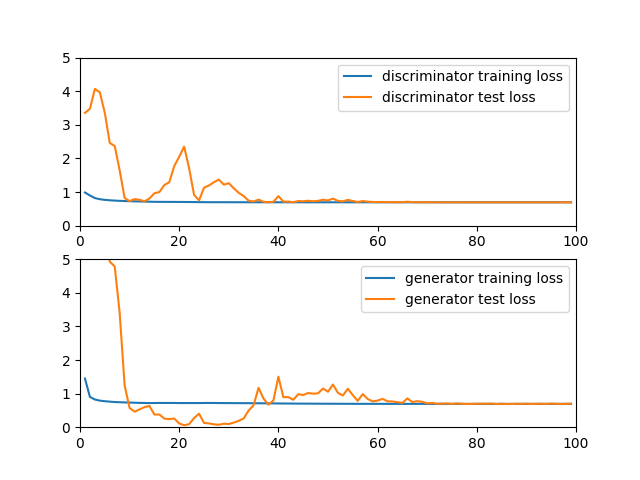

In [16]:
# for having interactive plots while training
%matplotlib notebook

plt.ion()
fig = plt.figure(1)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

xdata =[]
yy=[]
ax1.set_xlim(0,nb_epochs+1)
ax2.set_xlim(0,nb_epochs+1)
ax1.set_ylim(0,5)
ax2.set_ylim(0,5)
plot1, = ax1.plot(xdata,yy,label="discriminator training loss")
plot2, = ax1.plot(xdata,yy,label="discriminator test loss")
ax1.legend()
plot3, = ax2.plot(xdata,yy,label="generator training loss")
plot4, = ax2.plot(xdata,yy,label="generator test loss")
ax2.legend()

plt.show()  

train_loss = []
test_loss = []


In [17]:
## Here we perform the actual training by calling the train_GAN function
###nb_epochs = 10
X_gen = train_GAN(nb_epochs, (plot1,plot2,plot3,plot4), fig)
#update total number of epochs done for training
tot_epoch_done = tot_epoch_done + nb_epochs
plt.show()

Epoch  1  of  99
  0/180 [..............................] - ETA: 0s

/home/moneta/.local/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


179/180 [============================>.] - ETA: 0s
Testing for epoch : 1
generator  train and test loss 1.4475033 6.750366377830505
discrimin. train and test loss 0.9852277749114566 3.353419434267562
Epoch  2  of  99
179/180 [============================>.] - ETA: 0s
Testing for epoch : 2
generator  train and test loss 0.900659 7.021359026432037
discrimin. train and test loss 0.8962310430076387 3.4756091082221245
Epoch  3  of  99
179/180 [============================>.] - ETA: 0s
Testing for epoch : 3
generator  train and test loss 0.8239902 8.421862506866455
discrimin. train and test loss 0.8192601982090209 4.0681196451005235
Epoch  4  of  99
179/180 [============================>.] - ETA: 0s
Testing for epoch : 4
generator  train and test loss 0.7904848 7.963743066787719
discrimin. train and test loss 0.7850971129205492 3.965139678725973
Epoch  5  of  99
179/180 [============================>.] - ETA: 0s
Testing for epoch : 5
generator  train and test loss 0.7736299 6.783085620403289

179/180 [============================>.] - ETA: 0s
Testing for epoch : 38
generator  train and test loss 0.7093739 0.669663006067276
discrimin. train and test loss 0.6944603290822771 0.6941645234823227
Epoch  39  of  99
179/180 [============================>.] - ETA: 0s
Testing for epoch : 39
generator  train and test loss 0.70802146 0.7967754364013672
discrimin. train and test loss 0.6943892558415731 0.7083385080099106
Epoch  40  of  99
179/180 [============================>.] - ETA: 0s
Testing for epoch : 40
generator  train and test loss 0.7066316 1.5040204495191574
discrimin. train and test loss 0.6943313595321443 0.8774682663381099
Epoch  41  of  99
179/180 [============================>.] - ETA: 0s
Testing for epoch : 41
generator  train and test loss 0.7052293 0.8934006318449974
discrimin. train and test loss 0.6942489842573801 0.7134632676839828
Epoch  42  of  99
179/180 [============================>.] - ETA: 0s
Testing for epoch : 42
generator  train and test loss 0.70443356 

179/180 [============================>.] - ETA: 0s
Testing for epoch : 75
generator  train and test loss 0.693724 0.6949114695191383
discrimin. train and test loss 0.6935669160551495 0.6931248411536217
Epoch  76  of  99
179/180 [============================>.] - ETA: 0s
Testing for epoch : 76
generator  train and test loss 0.6936682 0.7087396755814552
discrimin. train and test loss 0.6935665763086742 0.6937323451042176
Epoch  77  of  99
179/180 [============================>.] - ETA: 0s
Testing for epoch : 77
generator  train and test loss 0.6936591 0.6973483577370644
discrimin. train and test loss 0.693566084239218 0.6931811586022377
Epoch  78  of  99
179/180 [============================>.] - ETA: 0s
Testing for epoch : 78
generator  train and test loss 0.6936782 0.6902339354157447
discrimin. train and test loss 0.6935649653275807 0.693299925327301
Epoch  79  of  99
179/180 [============================>.] - ETA: 0s
Testing for epoch : 79
generator  train and test loss 0.69367266 0.6

### Save the weights of the trained model

we save the weights for the generator and the discriminator and counting the total number of epochs we have been used for training

In [18]:
# save weights for discriminator and generator
generator_weights_file = 'generator_weights_epoch_'+ str(tot_epoch_done)+'.h5'
discriminator_weights_file = 'discriminator_weights_epoch_'+ str(tot_epoch_done)+'.h5'

generator.save_weights(generator_weights_file, overwrite=True)
discriminator.save_weights(discriminator_weights_file, overwrite=True)

print('save weights of generator and discriminator in',generator_weights_file,'and',discriminator_weights_file)

save weights of generator and discriminator in generator_weights_epoch_99.h5 and discriminator_weights_epoch_99.h5


## Load model  and generate images

Here we load the saved weights from the file and we generated new images data using the generator network

In [ ]:
generator_weights_file = 'generator_weights_epoch_99.h5'

#load the generator weights from a file
generator.load_weights(generator_weights_file)

X_gen = generator.predict(generate_random_data(nb_test), verbose=False)

## Analysis of the generated images

Here we look at the generated images and we make some coomparison with the original (true) images of the same type 
that we have provided as input for the GAN. 

We make sample plot of the single and average image profile, and we look at their distributions in the two coordinates and also at the mean and spread (standard deviation) that we obtain

As comparison we visualize the results either using matplotlib or (in case you have it installed) using the CERN data analysis software package, ROOT

### Display a single original (true) and a generated image

<IPython.core.display.Javascript object>


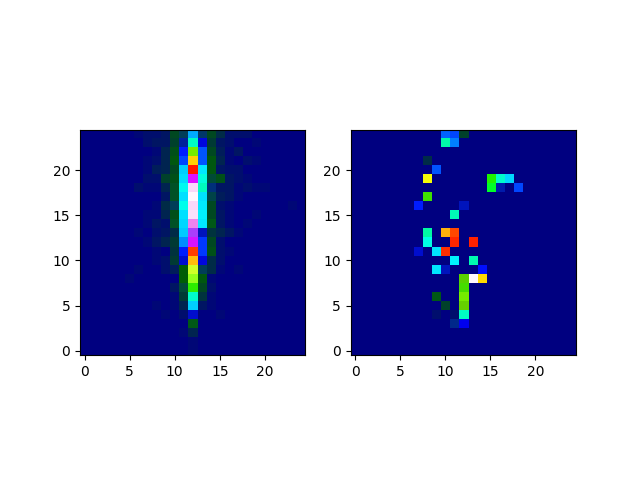

shape of test data (20000, 1, 25, 25)
image shape  (25, 25)
shape of gen data (20000, 1, 25, 25)
central image values true:
 [[0.04043153 0.05144737 0.05865308]
 [0.2421712  0.28350657 0.29750964]
 [0.0424585  0.04299707 0.03402728]] 
 generated:
 [[0.         0.05629801 0.05408437]
 [0.         0.         0.        ]
 [0.         0.05670462 0.        ]]


In [20]:
#make plot of generated images comparinig with true images
# X_gen is generated X_test is true
plt.figure(2)
plt.subplot(121)
print('shape of test data',X_test.shape)
nx = X_test.shape[2]
ny = X_test.shape[3]
image_true = X_test[1,:].reshape(nx,ny)
print('image shape ', image_true.shape)
#plot images - note matplotlib uses matrix convention x axis matrix columnx, y axis matrix rowx

plt.imshow(image_true.T, origin='lower',cmap=plt.cm.gist_ncar)


plt.subplot(122)
print('shape of gen data',X_gen.shape)
image_gen = X_gen[1,:].reshape(nx,ny)

plt.imshow(image_gen.T, origin='lower',cmap=plt.cm.gist_ncar)

plt.show()

print('central image values true:\n',image_true[11:14,11:14], '\n generated:\n',image_gen[11:14,11:14] )

### Display average of the profile of all true and generated images

<IPython.core.display.Javascript object>


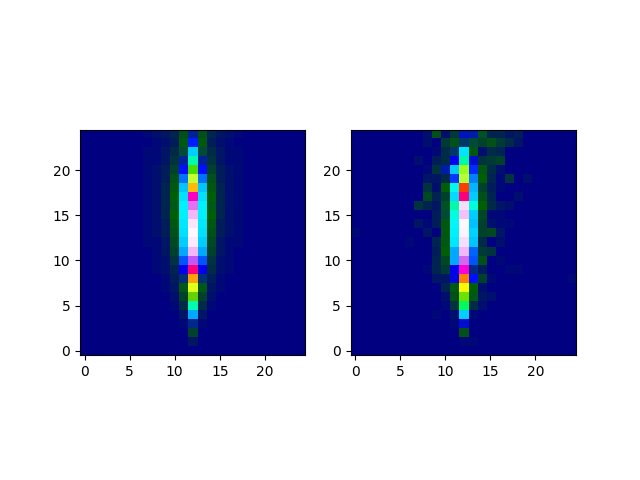

central image values true:
 [[0.03820997 0.04319453 0.04697869]
 [0.23498452 0.24574338 0.2489021 ]
 [0.03817864 0.04321892 0.04697569]] 
 generated:
 [[0.03692897 0.04789595 0.04928566]
 [0.22751123 0.2345894  0.2392073 ]
 [0.03274284 0.04008013 0.04327115]]


In [21]:
#make plot of generated images comparinig with true images
# X_gen is generated X_test is true
plt.figure(3)
plt.subplot(121)
average_image_true = np.mean(X_test,axis=0).reshape(nx,ny)

plt.imshow(average_image_true, origin='lower',cmap=plt.cm.gist_ncar)
plt.ylabel('Transverse')
plt.xlabel('Longitudinal')

plt.subplot(122)
average_image_gen = np.mean(X_gen,axis=0).reshape(nx,ny)
plt.imshow(average_image_gen, interpolation='none',origin='lower',cmap=plt.cm.gist_ncar)
plt.ylabel('Transverse')
plt.xlabel('Longitudinal')
plt.show()

print('central image values true:\n',average_image_true[11:14,11:14], '\n generated:\n',average_image_gen[11:14,11:14] )


### Display image profiles in the transverse and longitudinal planes

<IPython.core.display.Javascript object>


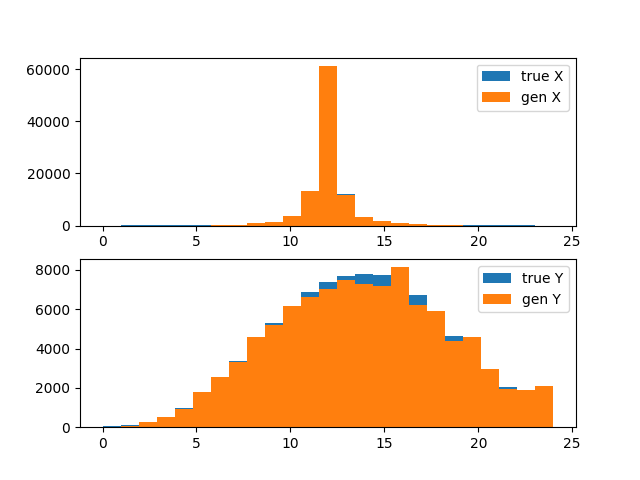

In [22]:
#compute projections summing on other axis (y for px and x for py)
px_true = np.sum(X_test[:,0,:,:],axis=2)
py_true = np.sum(X_test[:,0,:,:],axis=1)

px_gen = np.sum(X_gen[:,0,:,:],axis=2)
py_gen = np.sum(X_gen[:,0,:,:],axis=1)

nevt = X_test.shape[0]
nx = X_test.shape[2]
ny = X_test.shape[3]
xpos = np.array(range(0,nx))
#make a vector of (nevt x nx) for positions 
vpos = np.tile(xpos,(nevt,1))

n = nevt * nx
plt.figure(5)
plt.subplot(211)
plt.hist(vpos.reshape(nevt*nx),bins=nx,weights=px_true.reshape(nevt*nx),label="real transverse")
plt.hist(vpos.reshape(nevt*nx),bins=nx,weights=px_gen.reshape(nevt*nx),label="gen transverse")
plt.legend()
plt.show()

plt.subplot(212)
plt.hist(vpos.reshape(nevt*ny),bins=ny,weights=py_true.reshape(nevt*ny),label="real longitudinal")
plt.hist(vpos.reshape(nevt*ny),bins=ny,weights=py_gen.reshape(nevt*ny),label="gen longitudinal")
plt.legend()
plt.show()


### Display total Energy for original and generated images 

<IPython.core.display.Javascript object>


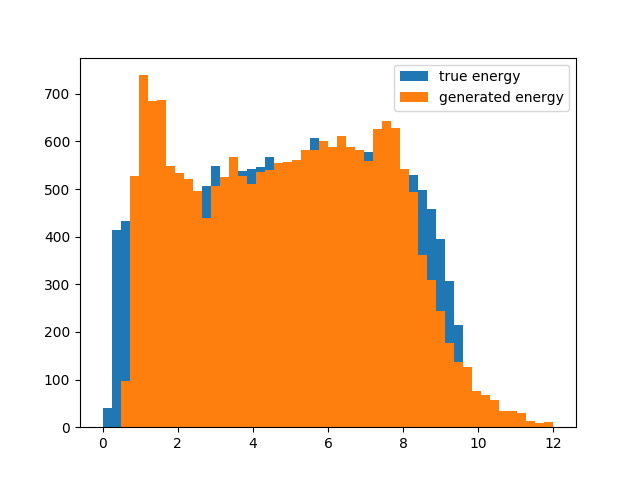

In [23]:
# by summing the obtained projections we get the total values
etot_true = np.sum(px_true, axis=1)
etot_gen = np.sum(px_gen, axis=1)

plt.figure(6)

plt.hist(etot_true,50,range=(0,12),label="real energy")

#plt.subplot(212)
plt.hist(etot_gen,50,range=(0,12),label="generated energy")
plt.legend()
plt.show()

### Compute image statistics 

We compute for each image the mean position in the transverse and longitudial coordinates and the corresponding spread (standard deviation)

In [24]:
#function to compute the statistics (weighted mean and weighted standard deviation)  
def calculate_stats(values):
    xpos = np.array(range(-12,13))
    #make a vector of (nevt x 25) for positions 
    vpos = np.tile(xpos,(values.shape[0],1))
    #compute average 
    mean = np.ma.average(vpos, weights=values, axis = 1)
    #compute varince - need to make an array of means same shape as vpos (next x 25)
    marray = np.tile(mean,(25,1)).transpose()
    variance = np.ma.average((vpos-marray)**2, weights=values, axis=1)
    stddev = np.sqrt(variance)
    return mean,stddev

In [32]:
## compute also mean and standard deviation in the two directions

meanx_true, stdx_true = calculate_stats(px_true)
meany_true, stdy_true = calculate_stats(py_true)


meanx_gen, stdx_gen = calculate_stats(px_gen)
meany_gen, stdy_gen = calculate_stats(py_gen)



plt.figure(7)
plt.subplot(221)

plt.hist(meanx_true,50,range=(-1,1),label='trans. mean (real)')
#plt.title('mean X (true)')

#plt.subplot(222)
plt.hist(meanx_gen,50, range=(-1,1),label='trans. mean (gen)')
plt.legend()
#plt.title('mean X (gen)')



plt.subplot(223)
plt.hist(stdx_true,50,range=(0,3),label='trans. std (real)')
#plt.title('std X (true)')         

#plt.subplot(224)          
plt.hist(stdx_gen,50, range=(0,3),label='trans. std (gen)')
#plt.title('std X (gen)')
plt.legend()
#plt.show()

#plt.figure(0)
plt.subplot(222)
plt.hist(meany_true,50, range=(-5,5),label='long. mean (real)')
#plt.title('mean Y (true)')          
#plt.subplot(222)          
plt.hist(meany_gen,50, range=(-5,5),label='long. mean (gen)')
#plt.title('mean Y (gen)')
plt.legend()

plt.subplot(224)
plt.hist(stdy_true,50,range=(0,8),label='long. std (real)')
#plt.title('std Y (true)')         

#plt.subplot(224)          
plt.hist(stdy_gen,50,range=(0,8),label='long. std (gen)')
#plt.title('std Y (gen)')
plt.legend()
          
plt.show()

The history saving thread hit an unexpected error (OperationalError('unable to open database file',)).History will not be written to the database.

Exception in thread IPythonHistorySavingThread:
Traceback (most recent call last):
  File "/home/moneta/.local/lib/python3.6/site-packages/IPython/core/history.py", line 834, in run
  File "</home/moneta/.local/lib/python3.6/site-packages/decorator.py:decorator-gen-23>", line 2, in writeout_cache
  File "/home/moneta/.local/lib/python3.6/site-packages/IPython/core/history.py", line 58, in needs_sqlite
  File "/home/moneta/.local/lib/python3.6/site-packages/IPython/core/history.py", line 780, in writeout_cache
  File "/home/moneta/.local/lib/python3.6/site-packages/IPython/core/history.py", line 764, in _writeout_input_cache
sqlite3.OperationalError: unable to open database file

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/moneta/.local/lib/python3.6/site-packages/ipykernel/iostream.py", line 97, in _event_pipe
AttributeError: '_thread._local' object has no attribute 'event_pipe'

During handling of the above exce

OSError: [Errno 24] Too many open files: '/home/moneta/.local/lib/python3.6/site-packages/matplotlib/backends/web_backend/js/mpl.js'

Error in sys.excepthook:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:



Original exception was:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:




## Analysis using ROOT 

We visualize the image and their statistics using histograms from the CERN data analysis software package, ROOT

First we book and fill histograms for the orginal (true) images

In [26]:
import ROOT

htrueXY = ROOT.TH2D("htrue","real shower profile",25,0,25,25,0,25)
htrueX = ROOT.TH1D("htruex","real images",25,0,25)
htrueY = ROOT.TH1D("htruey","real images",25,0,25)
htrueE = ROOT.TH1D("htrueE","real energy",100,0,12)

#prepare the arrays for filling the histograms
# note that we do using arrays to avoid performing loops in Python that is very slow

xpos = np.array(range(0,25))
xpos = xpos + 0.5
xvec = np.tile(xpos,(25,1)).T
xvec = xvec.reshape(25*25)
print(xvec.shape,xvec[1:50])

yvec = np.tile(xpos,(1,25))
yvec = yvec.reshape(25*25)
print(yvec.shape,yvec[1:50])

nevts = X_test.shape[0]
xvec = np.tile(xvec,(1,nevts))
yvec = np.tile(yvec,(1,nevts))

n = nevts * 25 * 25
weights = np.array( X_test.reshape( n), dtype = np.float64)
xvec = xvec.reshape(n)
yvec = yvec.reshape(n)


print(weights.shape, xvec.shape, yvec.shape)

# have transverse  vs longitudinal 
htrueXY.FillN(n,yvec, xvec, weights)
htrueX.FillN(n, xvec, weights)
htrueY.FillN(n, yvec, weights)

etot = np.array( np.sum( X_test, axis=(2,3)), dtype = np.float64)
etot_true = etot.reshape(nevts)
print (etot_true.shape)
weights = np.ones(nevts)
htrueE.FillN(nevts, etot_true, weights)
        


Welcome to JupyROOT 6.17/01
(625,) [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5
 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5]
(625,) [ 1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5 14.5
 15.5 16.5 17.5 18.5 19.5 20.5 21.5 22.5 23.5 24.5  0.5  1.5  2.5  3.5
  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5 14.5 15.5 16.5 17.5
 18.5 19.5 20.5 21.5 22.5 23.5 24.5]
(12500000,) (12500000,) (12500000,)
(20000,)


#### book and fill histograms for the generated images 

In [27]:
hgenXY = ROOT.TH2D("htrue","generated shower profile",25,0,25,25,0,25)
hgenX = ROOT.TH1D("htruex","generated images",25,0,25)
hgenY = ROOT.TH1D("htruey","generated images",25,0,25)
hgenE = ROOT.TH1D("htrueE","generated energy",100,0,12)


weights = np.array( X_gen.reshape( n), dtype = np.float64)
xvec = xvec.reshape(n)
yvec = yvec.reshape(n)

# have transverse  vs longitudinal 
hgenXY.FillN (n,yvec, xvec, weights)
hgenX.FillN(n, xvec, weights)
hgenY.FillN(n, yvec, weights)

etot = np.array( np.sum( X_gen, axis=(2,3)), dtype = np.float64)
etot_gen = etot.reshape(nevts)
print (etot_gen.shape)
weights = np.ones(nevts)
hgenE.FillN(nevts, etot_gen, weights)


(20000,)


Warning in <TROOT::Append>: Replacing existing TH1: htrue (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: htruex (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: htruey (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: htrueE (Potential memory leak).


In [28]:
# for the Javascript visualization of ROOT histogram 
%jsroot on

### DIsplay image profile for all events

In [29]:
c = ROOT.TCanvas("c1","",1000,500)
c.Divide(2,1)
c.cd(1)
htrueXY.SetMaximum(1.2*htrueXY.GetMaximum())
htrueXY.Draw("COLZ")

c.cd(2)
hgenXY.SetMaximum(1.2*htrueXY.GetMaximum())
hgenXY.Draw("COLZ")

c.Draw()


### DIsplay image profile projections in the two coordinates 

In [30]:
cname = "c2"
c = ROOT.TCanvas("c2","",1000,500)
c.Divide(2,1)
c1 = c.cd(1)
hs1 = ROOT.THStack("hs1","Transverse shower profile")
hs1.Add(htrueX)
hs1.Add(hgenX)
hs1.Draw("hist pfc nostack")

c1.BuildLegend()

c2 = c.cd(2)
hs2 = ROOT.THStack("hs2","Longitudinal shower profile")
hs2.Add(htrueY)
hs2.Add(hgenY)
hs2.Draw("hist pfc nostack")

c2.BuildLegend()
c.Draw()
            



### Display total energy 

In [31]:
c = ROOT.TCanvas()
hs = ROOT.THStack("hs","Total Deposited Energy")
hs.Add(htrueE)
hs.Add(hgenE)
hs.Draw("hist pfc nostack")
c.BuildLegend()
c.Draw()

In [36]:
print(train_loss,test_loss)

[[0.9852277749114566, 1.4475033], [0.8962310430076387, 0.900659], [0.8192601982090209, 0.8239902], [0.7850971129205492, 0.7904848], [0.7657996197541554, 0.7736299], [0.7530162483453751, 0.760732], [0.7439678635862138, 0.7490678], [0.7366480214728249, 0.7430669], [0.7311045567194621, 0.7379396], [0.7262423151069217, 0.7341512], [0.7221832828389274, 0.7285919], [0.7184690919187334, 0.7241104], [0.714701697230339, 0.72056395], [0.7111007273197174, 0.7172498], [0.7077779160605536, 0.7199183], [0.7067478189865748, 0.72128755], [0.7058394488361147, 0.7216997], [0.7050750795337889, 0.7212791], [0.704402635163731, 0.72131246], [0.7040902127822241, 0.71905273], [0.7031739585929446, 0.7190425], [0.7022545943657558, 0.7192605], [0.7007330136166678, 0.71932256], [0.6987025505966611, 0.7186557], [0.6974916855494181, 0.7205085], [0.6968222730689578, 0.7213379], [0.6964525947968165, 0.72076416], [0.6961293290058772, 0.7191791], [0.6958793924914466, 0.71818846], [0.6956620050801171, 0.71718574], [0.69